In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# PREPROCESSING

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch_generator1 = torch.Generator().manual_seed(42)
torch_generator2 = torch.Generator().manual_seed(43)

# 1. Load the Dataset

temp_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = '../data/vehicle-type-detection' # Assuming you run the script from the parent directory
full_dataset_temp = datasets.ImageFolder(data_dir, transform=temp_transform)

# 2. Split the Data
train_size = int(0.8 * len(full_dataset_temp))
val_size = len(full_dataset_temp) - train_size
train_dataset_temp, val_dataset_temp = random_split(full_dataset_temp, [train_size, val_size], generator=torch_generator1)


# 3. Calculate Mean and STD on train data
TEMP_BATCH_SIZE = 64
temp_train_loader = DataLoader(train_dataset_temp, batch_size=TEMP_BATCH_SIZE, shuffle=False)

def calculate_mean_and_std(loader):
    """Calculates channel-wise mean and standard deviation from a DataLoader."""
    channels_sum, channels_sq_sum, num_batches = 0, 0, 0

    # Iterate over the dataset and accumulate sums
    for data, _ in tqdm(loader, desc="Calculating Stats"):
        # data shape is (batch_size, channels, height, width)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sq_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    # Final calculation
    mean = channels_sum / num_batches
    # E[(X - mu)^2] = E[X^2] - (E[X])^2
    std = torch.sqrt(channels_sq_sum / num_batches - mean**2)

    # Convert tensors to lists/tuples of floats for use in transforms.Normalize
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_and_std(temp_train_loader)

# 4. Define Preprocessing Pipeline
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),     # Crop to 224x224 (standard input size for many CNNs)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),          # Converts image to a PyTorch Tensor and scales to [0, 1]
    transforms.Normalize(mean=MEAN, std=STD) # Apply normalization
])

full_dataset_transformed = datasets.ImageFolder(data_dir, transform=transform)

# Retain the original indices from the first random_split
# train_dataset and val_dataset are Subsets, we get their indices:
train_indices = train_dataset_temp.indices
val_indices = val_dataset_temp.indices

# Create the final, fully transformed train and validation datasets
# We use the original indices on the new fully-transformed dataset
train_dataset= Subset(full_dataset_transformed, train_indices)
val_test_dataset = Subset(full_dataset_transformed, val_indices)
val_dataset, test_dataset = random_split(val_test_dataset, [val_size // 2, val_size-val_size//2], torch_generator2)

# Check sizes to ensure split is preserved
print(f"Final Train Size: {len(train_dataset)}")
print(f"Final Validation Size: {len(val_dataset)}")

# 4. Create DataLoaders
# DataLoader handles batching, shuffling, and multi-threaded loading
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Calculating Stats:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating Stats: 100%|██████████| 17/17 [00:04<00:00,  3.79it/s]

Final Train Size: 1048
Final Validation Size: 131


In [4]:
full_dataset_temp.classes

['hatchback', 'motorcycle', 'pickup', 'sedan', 'suv']

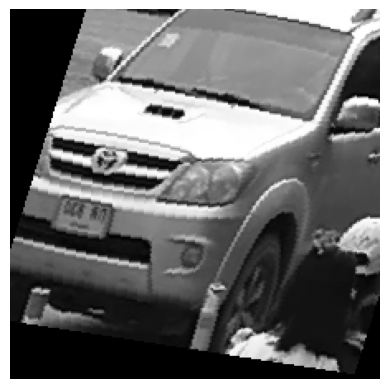

In [4]:
# DISPLAY RANDOM SAMPLE

# The arbitrary offset/scale is necessary to push the data into a visible range for Matplotlib.
# This makes the displayed image incorrect, but fulfills the request for a single-line display
plt.imshow(np.transpose(train_dataset[1023][0].numpy(), (1, 2, 0)), cmap='gray') 
plt.axis('off')
plt.show()

In [5]:
df_means = None
df_stds = None
umap_reducer = None

In [6]:
# FEATURE EXTRACTION
from skimage.feature import hog
import umap
from skimage.feature import local_binary_pattern

# input 2d grayscale numpy image
def lbp(im_np):
    im_lbp = im_np.copy()

    for i in range(1, im_np.shape[0] - 1):
        for j in range(1, im_np.shape[1] - 1):
            center = im_np[i, j]
            neighbour_patterns = []
            for l in range(-1, 2):
                for k in range(-1, 2):
                    if not (l == 0 and k == 0):
                        val = im_np[i+l, j+k]
                        neighbour_patterns.append(1 if val >= center else 0)
            texture = int(''.join(str(n) for n in neighbour_patterns), 2)
            im_lbp[i, j] = texture

    return im_lbp
     
def lbp_hist(im_lbp):
    hist = np.histogram(im_lbp.flatten(), bins=256)
    normalized_counts = hist[0] / hist[0].sum()
    return normalized_counts, hist[1]

def simple_radial_features(magnitude_spectrum_log, num_rings=16):
    """Creates a 1D array of radial features."""
    H, W = magnitude_spectrum_log.shape
    center_y, center_x = H // 2, W // 2
    
    # 1. Create the distance (radius) map 'r'
    Y, X = np.ogrid[0:H, 0:W]
    r = np.sqrt((Y - center_y)**2 + (X - center_x)**2)

    # 2. Use histogram2d to efficiently bin magnitude values by radius
    # The output 'hist' is the sum of magnitudes in each ring
    # The bins are defined by the radius map 'r'
    hist, r_edges, mag_edges = np.histogram2d(
        r.ravel(),
        magnitude_spectrum_log.ravel(),
        bins=(num_rings, 1), # Only 1 bin for the magnitude dimension (summing)
        range=[[0, np.max(r)], [np.min(magnitude_spectrum_log), np.max(magnitude_spectrum_log)]]
    )
    
    # 3. Features are the average magnitude per bin (sum divided by count)
    # The counts of elements in each bin is needed for averaging (not included here for simplicity)
    # Returning the sum of magnitudes in each bin, which is often used directly as a feature
    return hist[:, 0]

def torchvis_to_pandas(dataset, n=None):
    df = None
    L = len(dataset)
    if n is None:
        n = L
    processed_count = 0
    for _ in range(n):
        i = random.randint(0, L-1)
        if processed_count % 50 == 0:
            print(processed_count, '/', n)
        processed_count += 1

        im_np = torch.squeeze(dataset[i][0]).numpy()
        label = dataset[i][1]

        # manual lbp implementation
        # im_lbp = lbp(im_np)
        # im_lbp_hist, _im_lbp_hist_bins = lbp_hist(im_lbp)

        # try library for speed up
        im_np_int = (im_np * 255).astype(np.uint8)
        lbp_codes = local_binary_pattern(im_np_int, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp_codes.ravel(), bins=np.arange(0, 10), density=True)
        im_lbp_hist = hist

        hog_fd, hog_image = hog(
            im_np,
            orientations=8,
            pixels_per_cell=(8, 8),
            cells_per_block=(1, 1),
            visualize=True,
        )

        F = np.fft.fft2(im_np)
        F_shifted = np.fft.fftshift(F)
        magnitude_spectrum = np.abs(F_shifted)
        magnitude_spectrum_log = 20 * np.log(magnitude_spectrum + 1)
        radial_dft_feats = simple_radial_features(magnitude_spectrum_log)

        row = [*im_lbp_hist, *hog_fd, *radial_dft_feats, label]
        if df is None:
            lbp_cols = [f'lbp_{j}' for j in range(len(im_lbp_hist))]
            hog_cols = [f'hog_{j}' for j in range(len(hog_fd))]
            rdft_cols = [f'rdft_{j}' for j in range(len(radial_dft_feats))]
            column_names = lbp_cols + hog_cols + rdft_cols + ['label']
            df = pd.DataFrame([row], columns=column_names)
        else: df.loc[len(df)] = row
        
    return df

def normalize_df(df):
    global df_means
    global df_stds

    if df_means is None:
        df_means = df.mean()
    if df_stds  is None:
        df_stds = df.std()
    normalized_df = (df - df_means)/(df_stds + 1e-8)

    normalized_df['label'] = df['label']
    return normalized_df

def dimensionality_reduction(X):
    global umap_reducer
    
    X_dense = X.to_numpy().astype(np.float32)

    if umap_reducer is None:
        umap_reducer = umap.UMAP(
            n_components=50,  
            random_state=SEED,  
        )
        umap_reducer.fit(X_dense)
    
    reduced = umap_reducer.transform(X_dense)
    return reduced


def parse_torchvis(dataset, n=None):
    df = torchvis_to_pandas(dataset, n)
    df = normalize_df(df)
    y = df['label']
    X = df.drop(columns=['label'])
    X = dimensionality_reduction(X)

    return X, y

# example use
# X, y = parse_torchvis(train_dataset)

C:\Users\birko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X_train, y_train = parse_torchvis(train_dataset, 100)
X_val, y_val = parse_torchvis(val_dataset)

0 / 100
50 / 100


C:\Users\birko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


0 / 131
50 / 131
100 / 131


In [11]:
X_test, y_test = parse_torchvis(test_dataset)

0 / 131
50 / 131
100 / 131


In [8]:
print("Train classes:", np.unique(y_train))
print("Val classes:  ", np.unique(y_val))
#print("Test classes: ", np.unique(y_test))

Train classes: [0. 1. 2. 3. 4.]
Val classes:   [0. 1. 2. 3. 4.]


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=2000, random_state=SEED)
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
val_acc = accuracy_score(y_val, y_pred_val)

y_pred_test = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Val Accuracy:  {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Val Accuracy:  0.3740
Test Accuracy: 0.3817
